# We test the impact that misclassified galaxies (i.e., low redshift interlopers in a high redshift bin) would have on the estimated flux density, and how to quantify it. 

In [1]:
import pdb
import sys
import os
import json
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib import gridspec

from sklearn.model_selection import train_test_split

from astropy.io import fits

sys.path.append("../../..")
from simstackwrapper import SimstackWrapper
from simstacktoolbox import SimstackToolbox

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

conv_lir_to_sfr = 1.728e-10 / 10 ** 0.23
wavelengths = [24, 100, 160, 250, 350, 500, 850]

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

Import data we are trying to reproduce

In [2]:
pickle_path_suffix =  "cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10_X_4_foregnd_atonce_bootstrap_1-150"
underscore_suffix = ''
pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities",pickle_path_suffix)
file_path = os.path.join(pickle_path+underscore_suffix, pickle_path_suffix+".pkl")
path_ini_file = os.path.join(pickle_path+underscore_suffix, "cosmos2020_farmer.ini")
print(pickle_path)

D:\pickles/simstack\stacked_flux_densities\cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10_X_4_foregnd_atonce_bootstrap_1-150


In [3]:
# Get data and catalog
simstack_object = SimstackToolbox.import_saved_pickles(file_path)
catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)

## Define Simulation Functions
For this simulation, the measured is referred to as "source", and the interlopers as "int"

In [6]:
def sf_main_sequence(z, M):
    ''' From Bethermin 2017, adopted from Schreiber 2015'''
    a0 = 1.5
    a1 = 0.3
    m0 = 0.5
    m1 = 0.36
    a2 = 2.5
    sfr = 10 ** (np.log10(M**10/1e9) - m0 + a0*np.log10(1+z) - a1*(np.max([0, np.log10(M**10/1e9) - m1 - a2*np.log10(1+z)]))**2 )
    
    return sfr

In [7]:
def get_A_given_z_M_T(z,M,Tobs):
    LIR = np.log10(sf_main_sequence(z, M) / conv_lir_to_sfr)
    #print(LIR)
    A = np.linspace(-32.5,-36)
    Ldiff = 1e3
    for ai in A:
        Ltemp = np.log10(simstack_object.fast_LIR((ai,Tobs/(1+z)),z))
        if (Ltemp - LIR)**2 < Ldiff:
            Ldiff = (Ltemp - LIR)**2
            Aout = ai
    return Aout

In [8]:
# Simulate Galaxy Fluxes From Main Sequence (Used to model Nominal galaxy)
def simulate_bin_galaxy_seds(zmed, mmed, ngals, sig=0.2, A=None, T=None, show_params=False):
    '''Simulate galaxy fluxes as Gaussian distributed with width sig'''

    galaxy_seds = np.zeros([ngals, len(wavelengths)])
    for i in range(ngals):
        if not T:
            T = (32.9 + 4.6 * (zmed - 2)) / (1+zmed)
            if show_params:
                print("Schreiber Trf(z={0:0.1f})={1:0.1f}".format(zmed,(32.9 + 4.6 * (zmed - 2))))
        if not A:
            A = get_A_given_z_M_T(zmed,mmed,(32.9 + 4.6 * (zmed - 2)))
            if show_params:
                print("Schreiber A_MS(z={0:0.1f})={1:0.1f}".format(zmed,A))
                
        Anorm = np.random.normal(A, sig)
        galaxy_seds[i] = simstack_object.graybody_fn((Anorm,T), wavelengths)
        
    return galaxy_seds

In [9]:
sim_sed_sig = simulate_bin_galaxy_seds(zmed=7, mmed=10, ngals=68)

In [10]:
def simulate_interloper(zsig,zint=1.0,frac_int=0.2,msig=10.5,mint=10,ngals=200,Asig=None,Aint=None,show_params=True):
    
    sed_sig = simulate_bin_galaxy_seds(zsig, mmed=msig, ngals=ngals, A=Asig, sig=0.3,show_params=show_params)
    sed_int = simulate_bin_galaxy_seds(zint, mmed=mint, ngals=ngals, A=Aint, sig=0.3)
    #sed_sig = draw_bin_galaxy_seds(zsig,msig,ngals)
    #sed_int = draw_bin_galaxy_seds(zint,mint,ngals,use_outliers=True)
    cut_int = int(np.floor(np.shape(sed_sig)[0] * frac_int))
    sed_out = sed_sig.copy()
    sed_out[:cut_int] = sed_int[:cut_int]
    
    sed_dict = {'signal':sed_sig,'interloper':sed_int,'effective':sed_out,'redshift':{'signal':zsig, 'interloper': zint, 'effective': zsig}, 'ngals_bin':ngals}
    
    return sed_dict

In [11]:
sim_dict = simulate_interloper(zsig=9, zint=1, frac_int=.1, ngals=100)

Schreiber Trf(z=9.0)=65.1
Schreiber A_MS(z=9.0)=-34.1


In [12]:
def get_80_20_dict(self):
    ''' Get bootstrap flux densities of both the 80 and 20% bins'''
    bin_keys = list(self.config_dict['parameter_names'].keys())
    ds = [len(self.config_dict['parameter_names'][i]) for i in bin_keys]
    bands = list(self.results_dict['band_results_dict'].keys())
    nboots = self.config_dict['general']['error_estimator']['bootstrap']['iterations']
    
    bootstrap_dict = {}
    outliers_dict = {}

    for iwv in bands:
        bootstrap_matrix = np.zeros([nboots, *ds])
        outliers_matrix = np.zeros([nboots, *ds])
        for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
            for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
                    id_label = "__".join([zlab, mlab, plab])
                    label = "__".join([zlab, mlab, plab]).replace('.','p')
                    for ib in range(nboots):
                        blab = 'bootstrap_flux_densities_{0:0.0f}'.format(ib+1)
                        if label in self.results_dict['band_results_dict'][iwv][blab]:
                            bootstrap_matrix[ib,iz,im,ip] = self.results_dict['band_results_dict'][iwv][blab][label].value
                            outliers_matrix[ib,iz,im,ip] = self.results_dict['band_results_dict'][iwv][blab][label+'__bootstrap2'].value

        bootstrap_dict[iwv] = bootstrap_matrix
        outliers_dict[iwv] = outliers_matrix
    
    bootstrap_full = np.zeros([len(bands),*np.shape(bootstrap_dict[bands[0]])])
    outliers_full = np.zeros([len(bands),*np.shape(bootstrap_dict[bands[0]])])

    for iband, band in enumerate(bands):
        bootstrap_full[iband] = bootstrap_dict[band]
        outliers_full[iband] = outliers_dict[band]
        

    return_dict = {'bootstrap_dict': bootstrap_dict, 'outliers_dict':outliers_dict, 'bootstrap_array':bootstrap_full, 'outliers_array':outliers_full}

    return return_dict

In [13]:
eighty_twenty_dict = get_80_20_dict(simstack_object)

In [14]:
# Simulate bootstrap
def simulate_bootstrap(seds_in, ngals_bin, nboots=100, split=0.8):
    lenl = int(np.floor(ngals_bin*split))
    left = np.zeros([nboots, len(wavelengths)])
    right = np.zeros([nboots, len(wavelengths)])
    for i in range(nboots):
        np.random.shuffle(seds_in)
        left[i] = np.mean(seds_in[lenl:,:],axis=0)
        right[i] = np.mean(seds_in[:lenl,:],axis=0)
    return left, right

In [15]:
def find_deltaT_given_interloper(self, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75,10.25,10.75,11.5], 
                                 z_int = [0.25, 0.75, 1.25], m_int = [9.25, 9.75, 10.25]):
    '''Nested loop to estimate shift in Temperature from Nominal vs. Interloper Fraction, for different Interloper redshift and stellar mass'''
    frac_int = np.linspace(.02,.5,13)
    delta_t_dict = {} 
    
    return_dict = {'z_src':z_src, 'm_src':m_src, 'z_int':z_int, 'm_int':m_int, 'fraction_interloper': frac_int, 'delta_t_dict':delta_t_dict}

    for iz_src, z in enumerate(z_src):
        delta_t_dict[z] = {}
        for im, m in enumerate(m_src):

            deltat_matrix = np.zeros([len(z_int), len(m_int), len(frac_int)])
            for iz_int, zint in enumerate(z_int):
                for im_int, mint in enumerate(m_int):
                    for ifc, fc in enumerate(frac_int):
                        sim_dict = simulate_interloper(zsig=z, zint=zint, msig=m, mint=mint, frac_int = fc, ngals=100,show_params=False)
                        t_sed = np.zeros(2)
                        i=0
                        redshift = sim_dict['redshift']
                        for sed_key in sim_dict:
                            if 'redshift' not in sed_key and 'ngals_bin' not in sed_key and 'interloper' not in sed_key:
                                left, right = simulate_bootstrap(sim_dict[sed_key], sim_dict['ngals_bin'])
                                y = np.mean(left,axis=0)
                                yerr = (0.8 * np.cov(left,rowvar=False) + 0.2 * np.cov(right,rowvar=False))
                                p_z = simstack_object.fast_sed_fitter(wavelengths, y, np.sqrt(np.diag(yerr)), redshiftin=redshift[sed_key])
                                t_sed[i]=(1+redshift[sed_key])*p_z['T_observed'].value
                                #pdb.set_trace()
                                i+=1

                        deltat_matrix[iz_int, im_int, ifc] = t_sed[1] - t_sed[0]
                        #print("For z_src={0:0.2f} and m_src={1:0.2f}, z_int={2:0.2f},m_int={3:0.2f},frac={4:0.2f}, dT={5:0.1f}".format(z,m,zint,mint,fc,t_sed[1] - t_sed[0]))

            delta_t_dict[z][m] = deltat_matrix
            
    return return_dict

In [16]:
dt_dict = find_deltaT_given_interloper(simstack_object, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], m_int = [9.25, 9.75, 10.25])

In [17]:
def plot_deltaT(dt_dict):
    '''Plot the shift in Temperature from Nominal vs. Interloper Fraction, for different Interloper redshift and stellar mass'''
    zlen = len(dt_dict['z_src'])
    plen = len(dt_dict['m_src'])
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(plen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(28, 14))

    if 'fraction_interloper' not in dt_dict:
        frac_int = np.linspace(.02,.5,13)
    else:
        frac_int = dt_dict['fraction_interloper']

    zcolor=['r','b','g','y','c','m']
    for iz, (zsrc, zdict)in enumerate(dt_dict['delta_t_dict'].items()):
        mls = ['-','-.','--',':']
        for im, (msrc, mdict) in enumerate(dt_dict['delta_t_dict'][zsrc].items()):
            # Want to plot x-fraction, y-deltaT
            #print(zsrc, msrc)
            ax = plt.subplot(gs[im, iz])
            for iz_int, zint in enumerate(dt_dict['z_int']):
                for im_int, mint in enumerate(dt_dict['m_int']):
                    label = "z={0:0.1f}, M={1:0.1f}".format(zint, mint)
                    ax.plot(frac_int, mdict[iz_int,im_int,:],ls=mls[im_int],color=zcolor[iz_int], label=label)
                    if iz:
                        ax.set_yticklabels([])
                    else:
                        ax.set_ylabel("dT [K]")
                    
                    if iz == zlen-1:
                        ax.yaxis.set_label_position("right")
                        ax.set_ylabel("logM={0:0.1f}".format(msrc))
                    
                    if not im:
                        ax.set_title("z_bin={0:0.1f}".format(zsrc))
                        
                    if im != plen-1:
                        ax.set_xticklabels([]);
                    else:
                        ax.set_xlabel("Interloper %")
                        
            if not iz and not im:
                #ax.legend(bbox_to_anchor=(5, 0), loc="lower left",title='Interloper Legend')                
                ax.legend(loc="lower right",title='Interloper Legend')

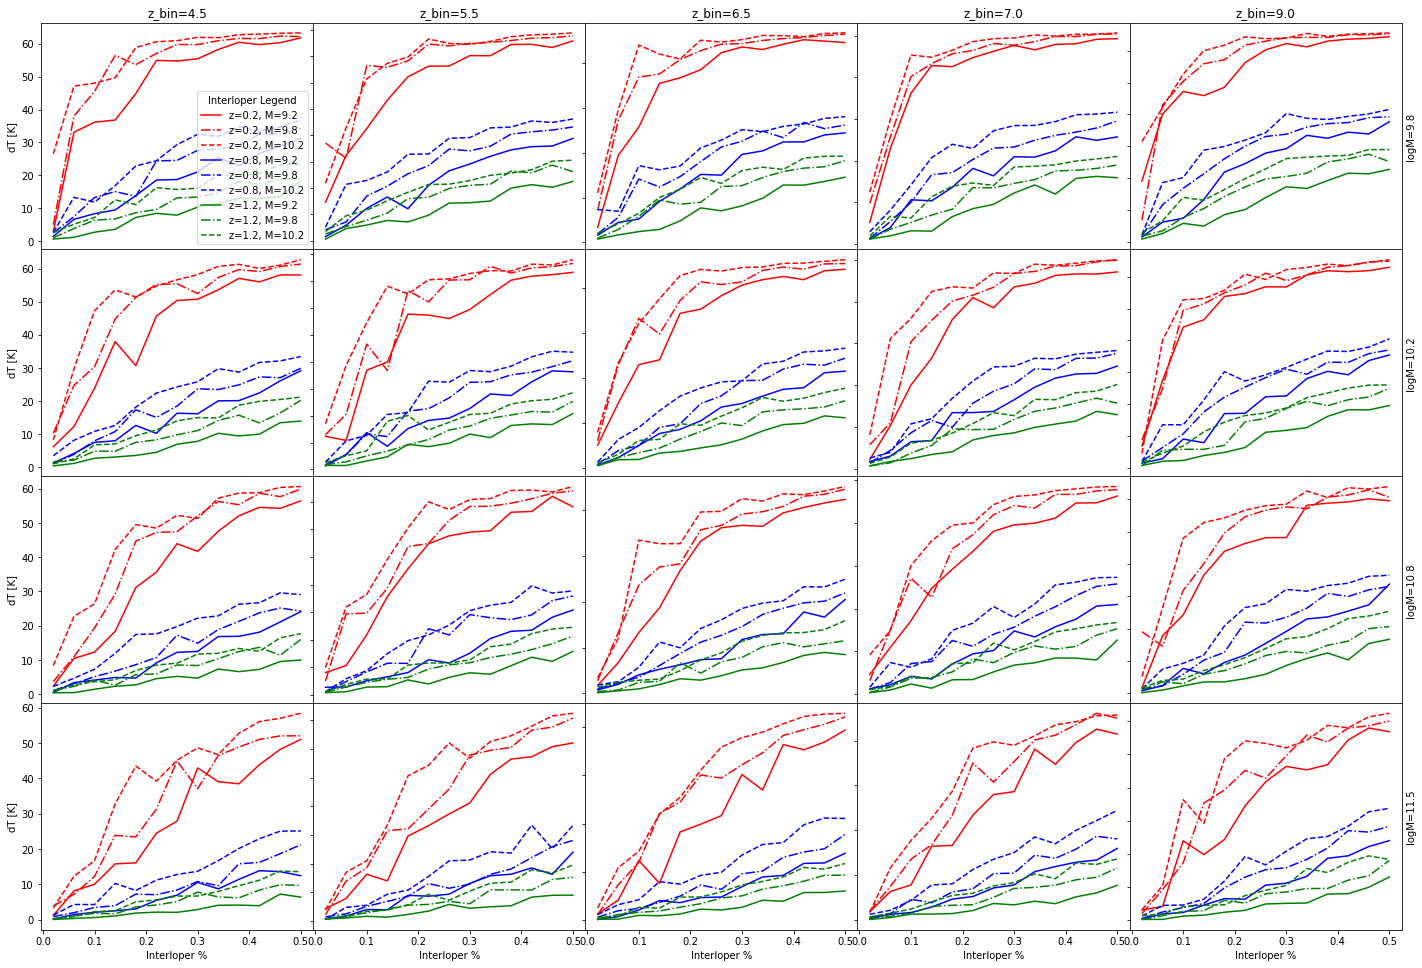

In [18]:
plot_deltaT(dt_dict)

# Investigate Effect of Interlopers 
We ask, if the nominal SED followed the Schreiber 2015 main-sequence, how many and what redshift/mass would the interlopers have to consist to 
effectively look like the measured SED.

In [19]:
def find_interloper_vals(self, eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75,10.25,10.75,11.5], 
                         z_int = [0.25, 0.75, 1.25], m_int = [9.75, 10.25, 10.75]):
    bin_keys = list(self.config_dict['parameter_names'].keys())
    zlabels = self.config_dict['parameter_names'][bin_keys[0]]
    mlabels = self.config_dict['parameter_names'][bin_keys[1]]
    
    zbins = np.array(self.config_dict['distance_bins']['redshift'])
    zmid = (zbins[1:]+zbins[:-1])/2
    mmid = np.array([(float(i.split('_')[2])+float(i.split('_')[3]))/2  
                     for i in self.config_dict['parameter_names'][bin_keys[1]]])

    #frac_int = np.linspace(.05,.8,16)
    frac_int = np.linspace(.02,.5,13)
    best_int = {} 
    chi_2 = {}
    
    return_dict = {'z_src':z_src, 'm_src':m_src, 'z_int':z_int, 'm_int':m_int, 'best_int':best_int, 'chi_2':chi_2}
    
    zlen = len(z_src)
    plen = len(m_src)
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(plen, zlen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(28, 14))
    
    for iz_src, z in enumerate(z_src):
        best_int[z] = {}
        chi_2[z] = {}
        for im, m in enumerate(m_src):
            indz = np.argmin(abs(zmid-z))
            indm = np.argmin(abs(mmid-m))
            s_boots = np.mean(eighty_twenty_dict['bootstrap_array'],axis=1)[:,indz,indm,1]
            
            min_matrix = np.zeros([len(z_int), len(m_int), len(frac_int)])
            min_matrix2 = np.zeros([len(z_int), len(m_int), len(frac_int)])
            min_matrix3 = np.zeros([len(z_int), len(m_int), len(frac_int)])
            for iz_int, zint in enumerate(z_int):
                for im_int, mint in enumerate(m_int):
                    for ifc, fc in enumerate(frac_int):
                        sim_dict = simulate_interloper(zsig=z, zint=zint, msig=m, mint=mint, frac_int = fc, ngals=100,show_params=False)
                        left, right = simulate_bootstrap(sim_dict['effective'], sim_dict['ngals_bin'])
                        s_model = np.mean(left,axis=0) 
                        ind_boots = s_boots > 0
                        min_matrix3[iz_int, im_int, ifc] = (np.sum(s_model[ind_boots] - s_boots[ind_boots])**2)/np.sum(ind_boots) 
                        min_matrix[iz_int, im_int, ifc] = np.sum((s_model[ind_boots] - s_boots[ind_boots])**2/np.var(left[:,ind_boots]))
                        
                        cov_d = np.cov(left[:,ind_boots], rowvar=False)
                        delta_y = abs(s_model[ind_boots] - s_boots[ind_boots])
                        #pdb.set_trace()
                        min_matrix2[iz_int, im_int, ifc] =np.matmul(delta_y, np.matmul(np.linalg.inv(cov_d), delta_y))
                        
            ind_min = np.where(min_matrix == min_matrix.min())
            best_int[z][m] = z_int[ind_min[0][0]],m_int[ind_min[1][0]],frac_int[ind_min[2][0]]
            chi_2[z][m] = min_matrix.min()
            #pdb.set_trace()
            #print("For z_src={0:0.2f} and m_src={1:0.2f}, z_int={2:0.2f},m_int={3:0.2f},frac={4:0.2f}".format(z,m,z_int[ind_min[0][0]],m_int[ind_min[1][0]],frac_int[ind_min[2][0]]))
            
            ax = plt.subplot(gs[im, iz_src])
            #ax.set_yticklabels([])
            
            plot_dict=simulate_interloper(zsig=z, zint=z_int[ind_min[0][0]], msig=m, mint=m_int[ind_min[1][0]], frac_int = frac_int[ind_min[2][0]], ngals=100, show_params=False)
            i=0
            color = ['m','r','c']
            ls = [':',':',':']
            redshift = plot_dict['redshift']
            for sed_key in plot_dict:
                if 'redshift' not in sed_key and 'ngals_bin' not in sed_key:
                    #print(sed_key,'z=',redshift[sed_key])
                    left, right = simulate_bootstrap(plot_dict[sed_key], plot_dict['ngals_bin'])
                    y = np.mean(left,axis=0)
                    yerr = (0.8 * np.cov(left,rowvar=False) + 0.2 * np.cov(right,rowvar=False))
                    p_z = simstack_object.fast_sed_fitter(wavelengths, y, np.sqrt(np.diag(yerr)), redshiftin=redshift[sed_key])
                    ax.scatter(wavelengths, 1e3*np.mean(left,axis=0), facecolors='none', edgecolors=color[i])
                    ax.errorbar(wavelengths,1e3*y, 1e3*np.sqrt(np.diag(yerr)), 0, 'none', color=color[i])
                    ax.plot(wavelengths, 1e3*simstack_object.fast_sed(p_z, wavelengths)[0],color[i]+ls[i], label='T'+sed_key+'(rf)={0:0.1f}({1:0.1f})'.format(p_z['T_observed'].value,(1+redshift[sed_key])*p_z['T_observed'].value))

                    i += 1
                    #pdb.set_trace()
            
            indz = np.argmin(abs(zmid-z))
            indm = np.argmin(abs(mmid-m))    
            #real_label = "z_int={0:0.2f},m_int={1:0.2f},frac={2:0.2f}".format(z_int[ind_min[0][0]],m_int[ind_min[1][0]],frac_int[ind_min[2][0]])
            #real_label = "z={0:0.1f}, m={1:0.1f}, zi={2:0.1f}, mi={3:0.1f}, frac={4:0.2f}".format(z,m,z_int[ind_min[0][0]],m_int[ind_min[1][0]],frac_int[ind_min[2][0]])
            #real_label = "percent interlopers={0:0.0f}".format(100*frac_int[ind_min[2][0]])
            real_label = "percent interlopers={0:0.0f} (chi2={1:0.2f})".format(100*frac_int[ind_min[2][0]],min_matrix.min())
            ax.plot(wavelengths, 1e3*np.mean(eighty_twenty_dict['bootstrap_array'],axis=1)[:,indz,indm,1],'c-',lw=2,label=real_label);
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.legend(loc='lower left');
            if iz_src:
                ax.set_yticklabels([]);
                
            if iz_src:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel("flux density")

            if iz_src == zlen-1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel("Source logM={0:0.1f}".format(m))

            if not im:
                ax.set_title("z_bin={0:0.1f}".format(z))

            if im != plen-1:
                ax.set_xticklabels([]);
            else:
                ax.set_xlabel("wavelength")
                
            #pdb.set_trace()
    return return_dict

In [20]:
def plot_interloper_dicts(dict_list):

    plen = len(dict_list)
    width_ratios = [i for i in np.ones(plen)]
    gs = gridspec.GridSpec(1, plen, width_ratios=width_ratios,
                           wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(11*plen, 7))
    
    for idict, dict_in in enumerate(dict_list):
        
        z_src = dict_in['z_src']
        m_src = dict_in['m_src']
        z_int = dict_in['z_int']
        m_int = dict_in['m_int']
        color = ['r','g','b','m','y','c']
        m_int = dict_in['m_int']
        symb = ['o','s','d','x','.']

        y_z = np.zeros([len(z_src),len(m_src)])
        y_m = np.zeros([len(z_src),len(m_src)])
        y_frac = np.zeros([len(z_src),len(m_src)])
        y_err = np.zeros([len(z_src),len(m_src)])

        for ims, ms in enumerate(m_src):
            for izs, zs in enumerate(z_src):
                y_z[izs,ims] = dict_in['best_int'][zs][ms][0]
                y_m[izs,ims] = dict_in['best_int'][zs][ms][1]
                y_frac[izs,ims] = dict_in['best_int'][zs][ms][2]
                y_err[izs,ims] = dict_in['chi_2'][zs][ms]

            ax = plt.subplot(gs[idict])
            #ax.plot(z_src, y_frac[:,ims],label=str("Source Mass = {0:0.1f}".format(ms)))
            ax.errorbar(z_src, y_frac[:,ims],0.01*y_err[:,ims],label=str("Source Mass = {0:0.1f}".format(ms)))
            ax.set_title('For Interloper Mass = '+str(dict_in['m_int'][0]))
        if idict:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('interloper fraction')
        ax.set_ylim([0.0,0.75])
        ax.set_xlabel('redshift') 
        ax.legend(loc='upper right')

The following series of figures are for single *Interloper* redshift and stellar mass.  For example, in interloper_dict_00, the interlopers are at z=0.25 with stellar mass = 10^9.25, and for interloper_dict_01, the interlopers are at z=0.25 with stellar mass = 10^9.75.

Only measured SEDs at z>4 are estimated.  Each grid of panels shows the different the interloper SED in red, the nominal SED in purple, and the measured SEDs in cyan (solid line). The cyan dotted line is the effective SED for the percent of interlopers, shown in the legend.  Also shown in the legend is the Nominal Temperature (Tsignal), the Interloper Temperature, and the Effective Temperature.  

A summary of the findings is shown below.

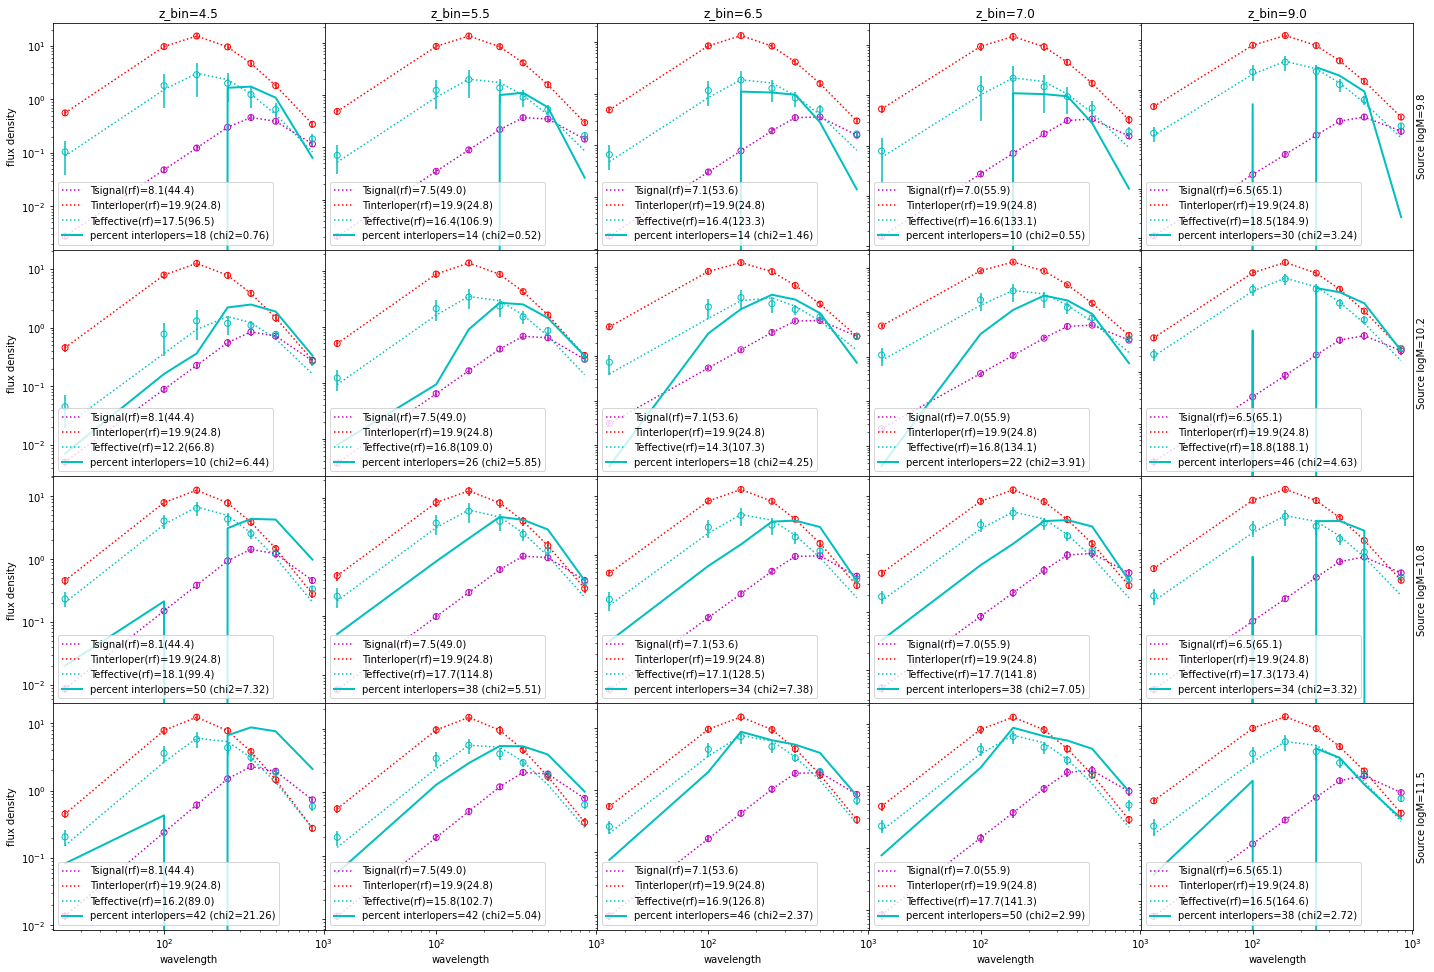

In [21]:
interloper_dict_00 = find_interloper_vals(simstack_object,eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], z_int=[0.25], m_int = [9.25])

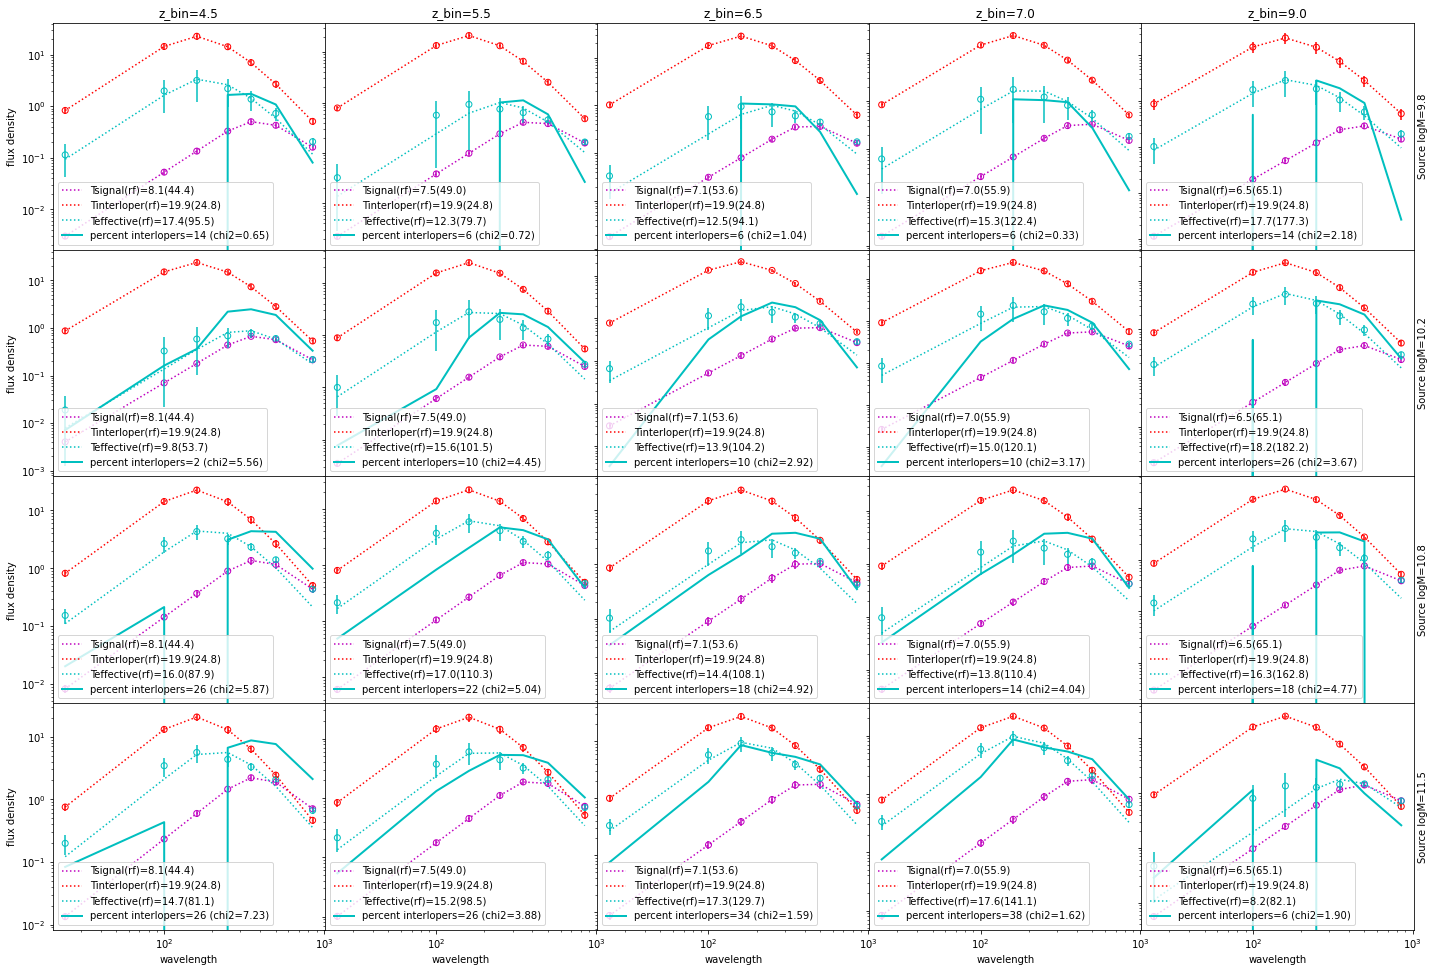

In [22]:
interloper_dict_01 = find_interloper_vals(simstack_object,eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], z_int=[0.25], m_int = [9.75])

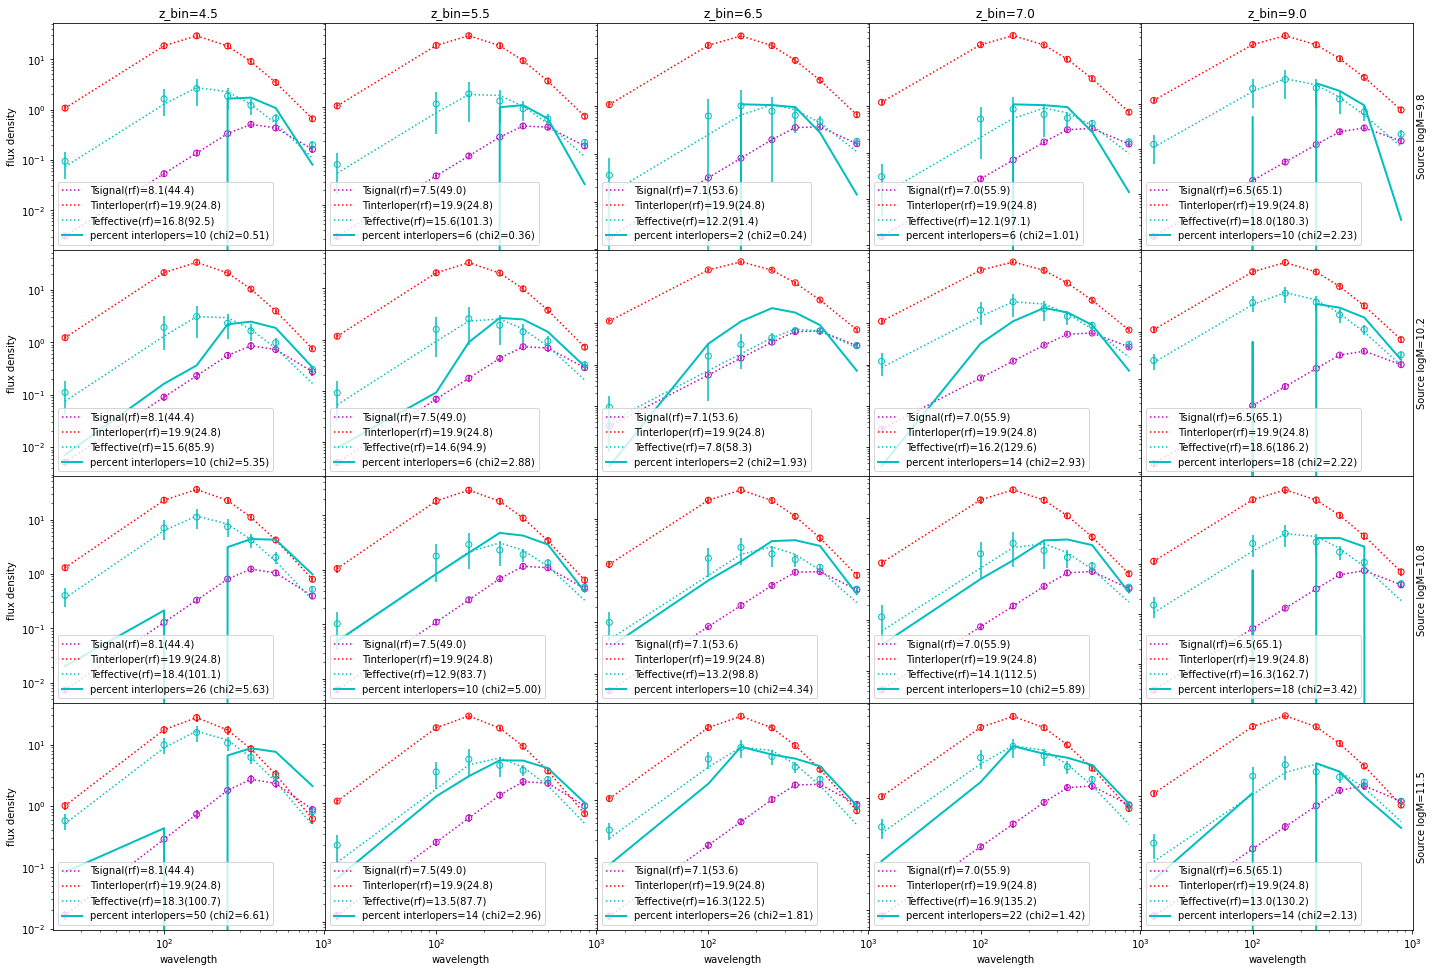

In [23]:
interloper_dict_02 = find_interloper_vals(simstack_object,eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], z_int=[0.25], m_int = [10.25])

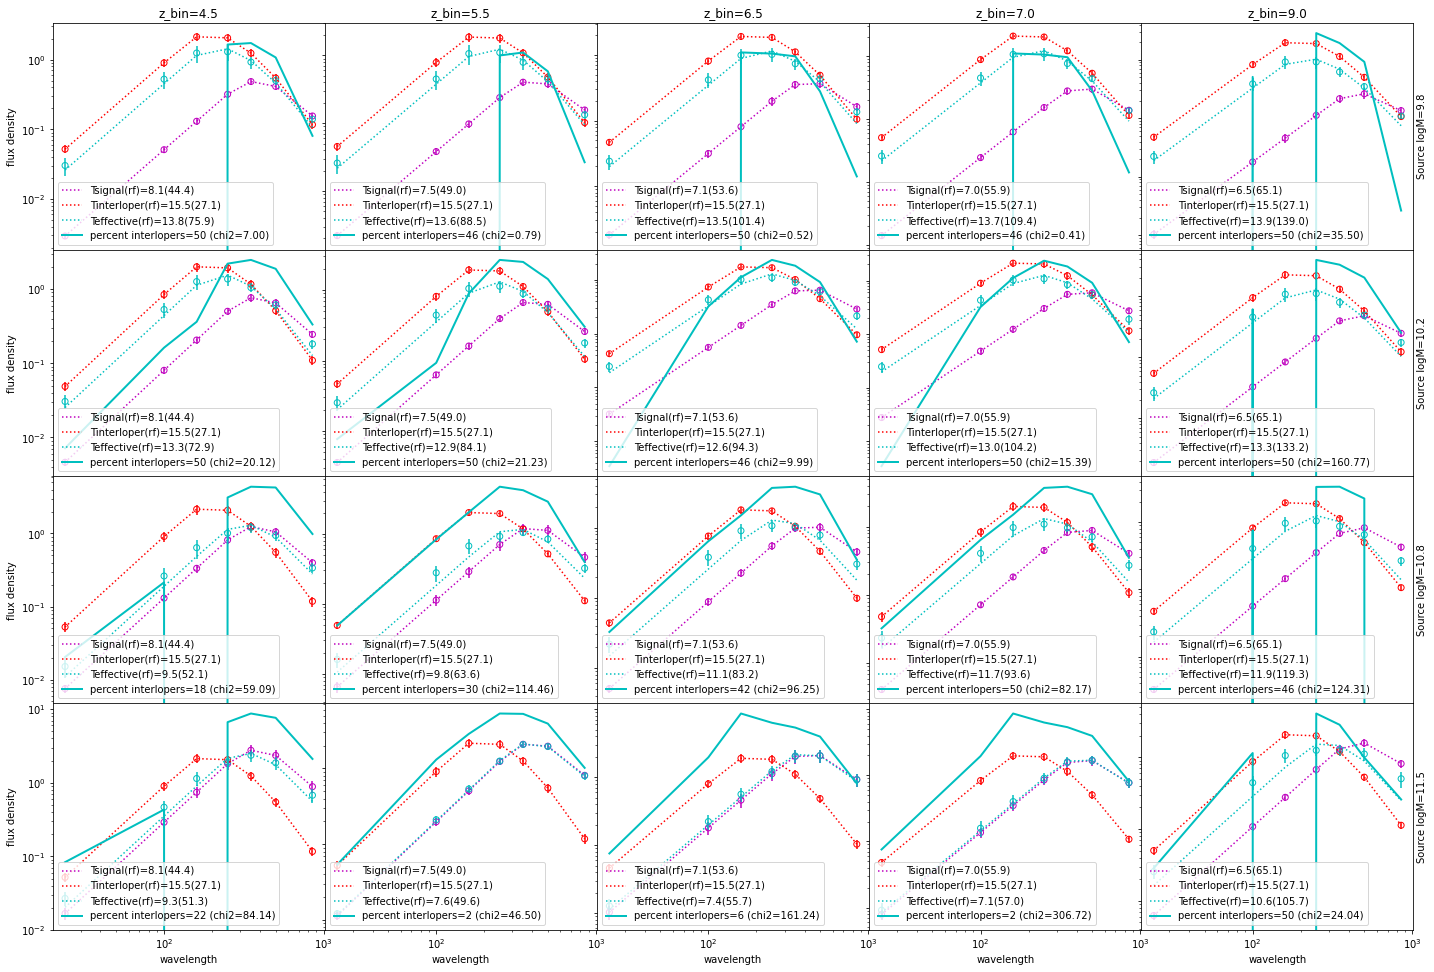

In [24]:
interloper_dict_10 = find_interloper_vals(simstack_object,eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], z_int=[0.75], m_int = [9.25])

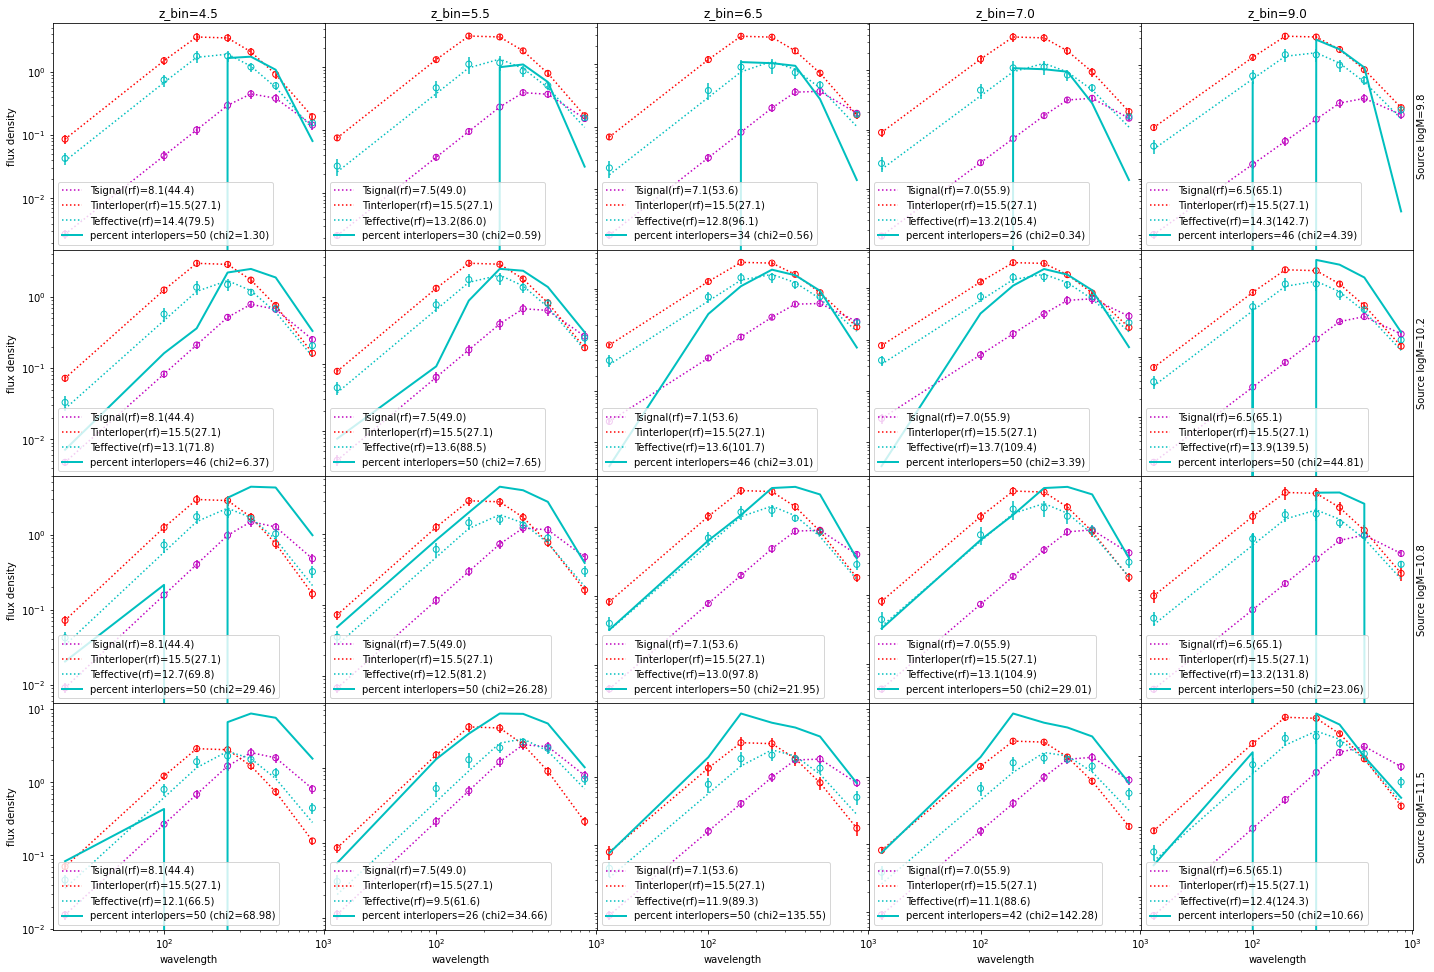

In [25]:
interloper_dict_11 = find_interloper_vals(simstack_object,eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], z_int=[0.75], m_int = [9.75])

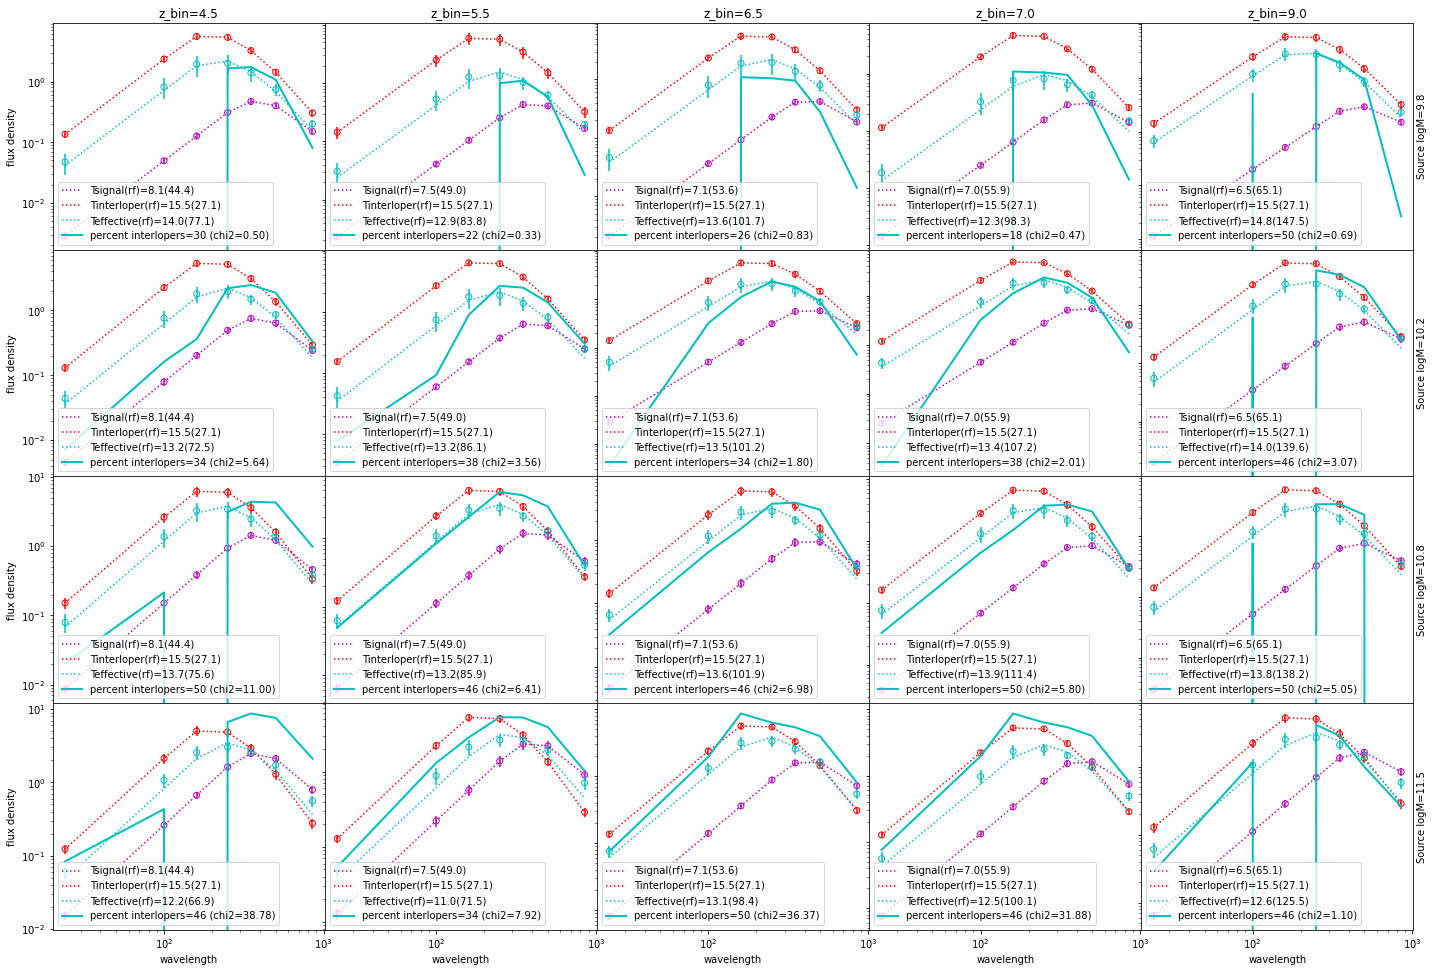

In [26]:
interloper_dict_12 = find_interloper_vals(simstack_object,eighty_twenty_dict, z_src=[4.5,5.5,6.5,7,9], m_src=[9.75, 10.25,10.75,11.5], z_int=[0.75], m_int = [10.25])

In [27]:
def plot_interloper_grid(grid_dict):

    for z_grid, dict_list in grid_dict.items():
        plen = len(dict_list)
        width_ratios = [i for i in np.ones(plen)]
        gs = gridspec.GridSpec(1, plen, width_ratios=width_ratios,
                               wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
        fig = plt.figure(figsize=(11*plen, 7))

        for idict, dict_in in enumerate(dict_list):

            z_src = dict_in['z_src']
            m_src = dict_in['m_src']
            z_int = dict_in['z_int']
            m_int = dict_in['m_int']
            color = ['r','g','b','m','y','c']
            m_int = dict_in['m_int']
            symb = ['o','s','d','x','.']

            y_z = np.zeros([len(z_src),len(m_src)])
            y_m = np.zeros([len(z_src),len(m_src)])
            y_frac = np.zeros([len(z_src),len(m_src)])
            y_err = np.zeros([len(z_src),len(m_src)])

            for ims, ms in enumerate(m_src):
                for izs, zs in enumerate(z_src):
                    y_z[izs,ims] = dict_in['best_int'][zs][ms][0]
                    y_m[izs,ims] = dict_in['best_int'][zs][ms][1]
                    y_frac[izs,ims] = dict_in['best_int'][zs][ms][2]
                    y_err[izs,ims] = dict_in['chi_2'][zs][ms]

                ax = plt.subplot(gs[idict])
                #ax.plot(z_src, y_frac[:,ims],label=str("Source Mass = {0:0.1f}".format(ms)))
                ax.errorbar(z_src, y_frac[:,ims],0.01*y_err[:,ims],label=str("Source Mass = {0:0.1f}".format(ms)))
                ax.set_title('For Interloper Mass = '+str(dict_in['m_int'][0]))
            if idict:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel('interloper fraction')
            ax.set_ylim([0.0,0.75])
            ax.set_xlabel('redshift') 
            ax.legend(loc='upper right')
            
            if idict == len(dict_list)-1:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel("Interloper {}".format(z_grid))

## Summary
Interloper summary shown for the two low redshift interloper sets. Error bars reflect the quality of fit of the effective SED (there are some bins where the combination of zint/mint has no effective solution).

As expected, low-mass interlopers require a higher interloper fraction to make up the signal, and fewer interlopers are needed to effectively contaminate the low-mass measurements. 

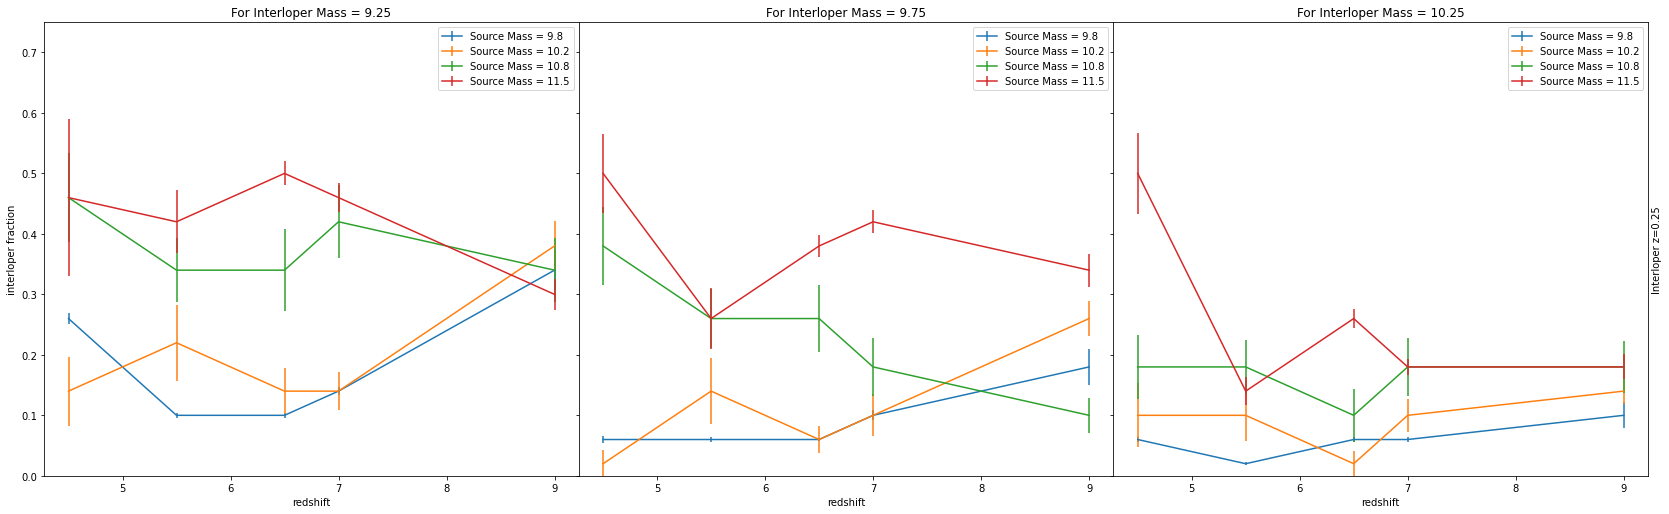

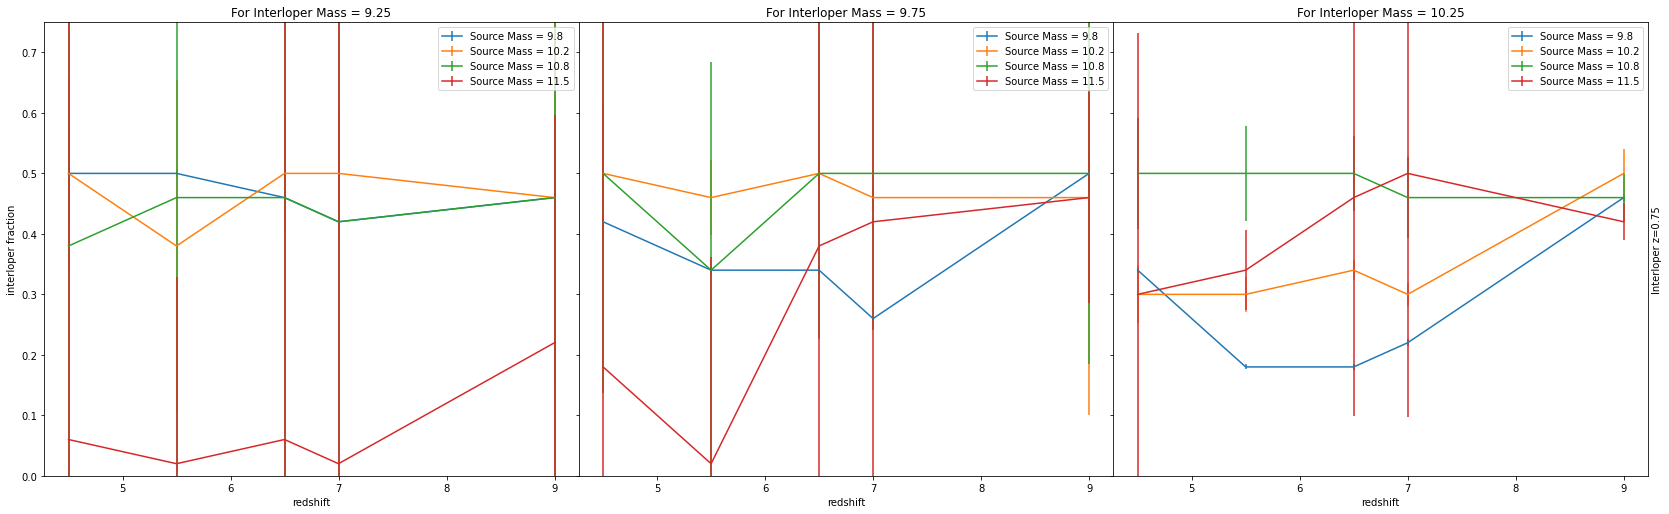

In [209]:
grid_dict = {'z=0.25':[interloper_dict_00,interloper_dict_01,interloper_dict_02],
             'z=0.75':[interloper_dict_10,interloper_dict_11,interloper_dict_12],}
plot_interloper_grid(grid_dict)